# Explore the dataset


In this notebook, we will perform an EDA (Exploratory Data Analysis) on the processed Waymo dataset (data in the `processed` folder). In the first part, you will create a function to display 

In [1]:
import glob

import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from utils import get_dataset
from scipy.ndimage import gaussian_filter

%matplotlib inline

In [2]:
# "data/processed/*.tfrecord"
dataset = get_dataset("data/waymo/test/*.tfrecord")

INFO:tensorflow:Reading unweighted datasets: ['data/waymo/test/*.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['data/waymo/test/*.tfrecord']
INFO:tensorflow:Number of filenames to read: 15
Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.deterministic`.
Instructions for updating:
Use `tf.data.Dataset.map()


## Write a function to display an image and the bounding boxes

Implement the `display_instances` function below. This function takes a batch as an input and display an image with its corresponding bounding boxes. The only requirement is that the classes should be color coded (eg, vehicles in red, pedestrians in blue, cyclist in green).

In [3]:
def generate_colors(num_classes=4):
    """
    Vehicles, Pedestrians, Cyclists, Signs
    """
    colors = {
        1: (255, 0, 0),
        2: (0, 0, 255),
        4: (0, 255, 0)
    }
    return colors

In [4]:
def display_instances(batch):
    """
    This function takes a batch from the dataset and display the image with 
    the associated bounding boxes.
    """
    image = batch['image'].numpy()
    bboxes = batch['groundtruth_boxes'].numpy()
    classes = batch['groundtruth_classes'].numpy()
        
    h, w, _ = image.shape
 
    for box, obj_class in zip(bboxes, classes):
        
        ymin = box[0]
        xmin = box[1]
        ymax = box[2]
        xmax = box[3]
        x1 = int(xmin * w)
        y1 = int(ymin * h)
        x2 = int(xmax * w)
        y2 = int(ymax * h)
    
        # cv2.rectangle(image, (left, top), (right, bottom), color, thickness)
        cv2.rectangle(image, (x1, y1), (x2, y2), colors[obj_class], 2)
    
    f, (ax1) = plt.subplots(1, 1, figsize=(10,10))
    f.subplots_adjust(hspace = .2, wspace = .05)
    
    ax1.imshow(image)

## Display 10 images 

Using the dataset created in the second cell and the function you just coded, display 10 random images with the associated bounding boxes. You can use the methods `take` and `shuffle` on the dataset.

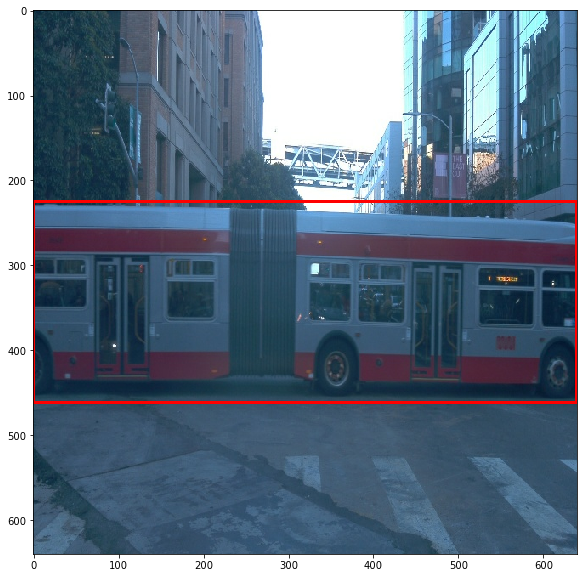

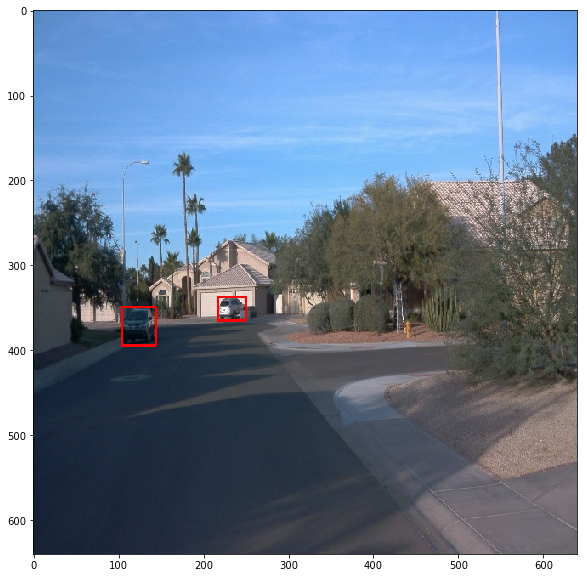

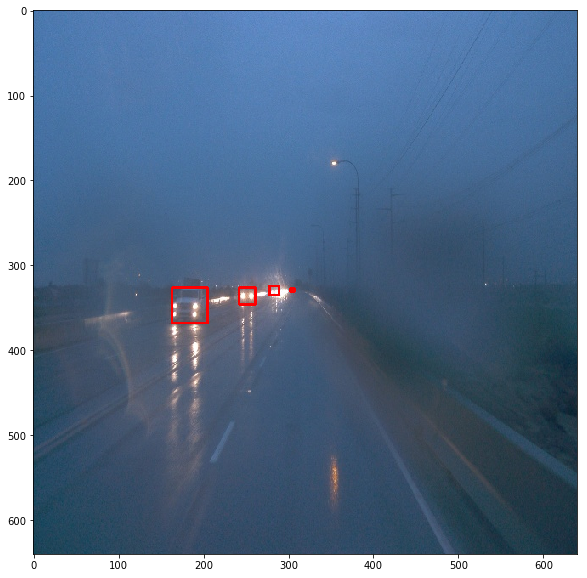

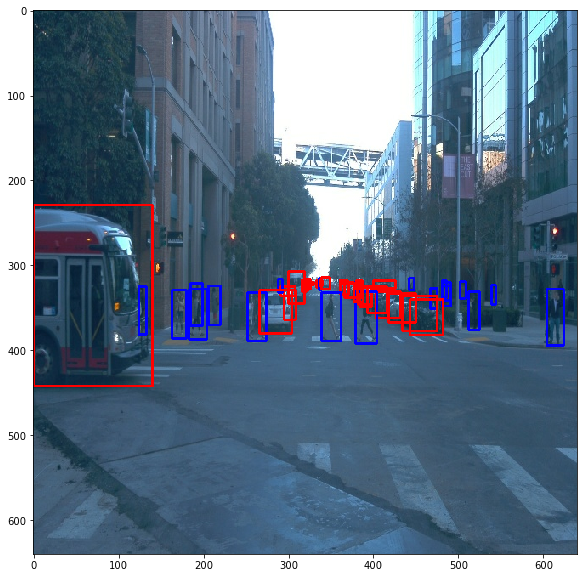

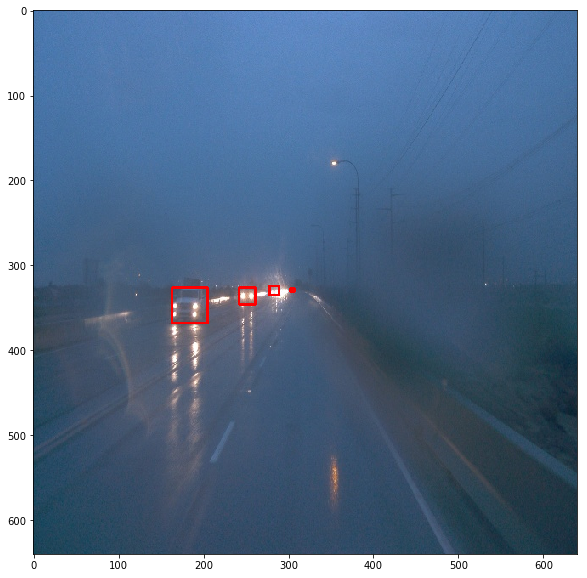

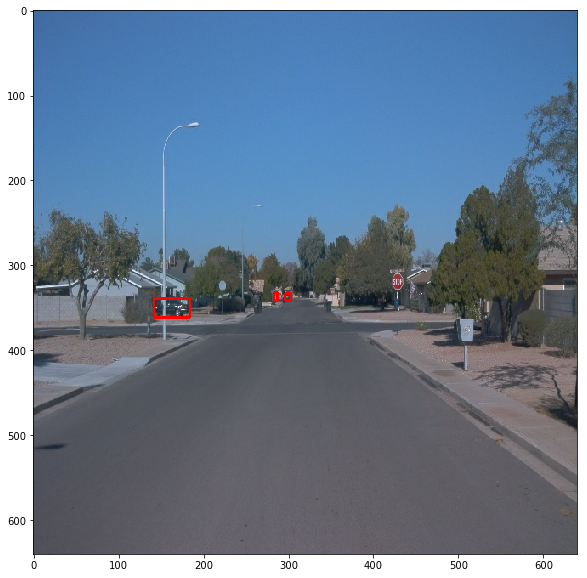

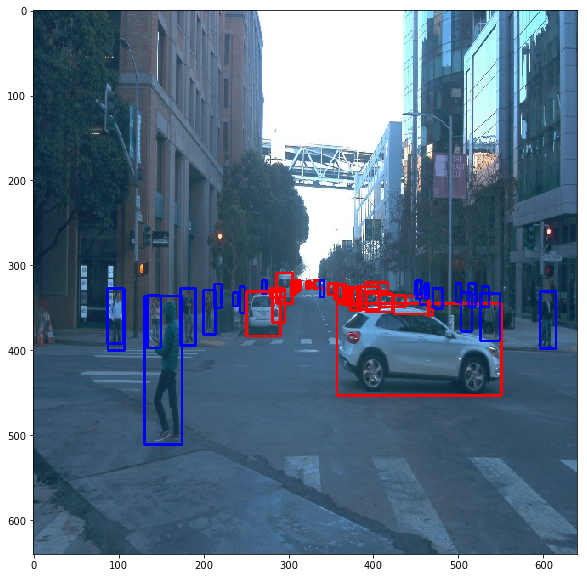

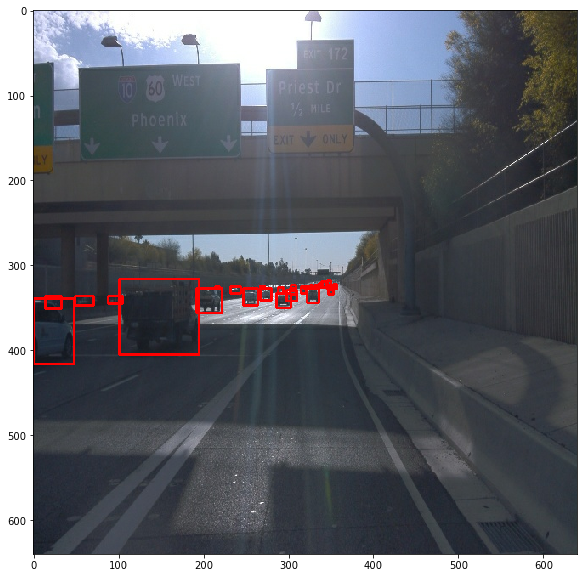

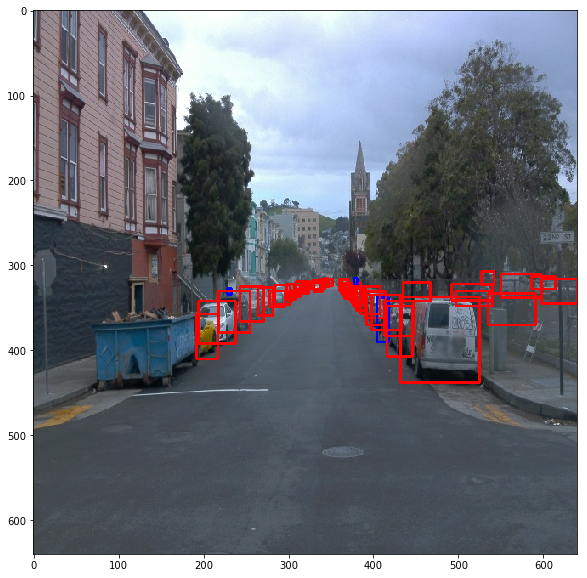

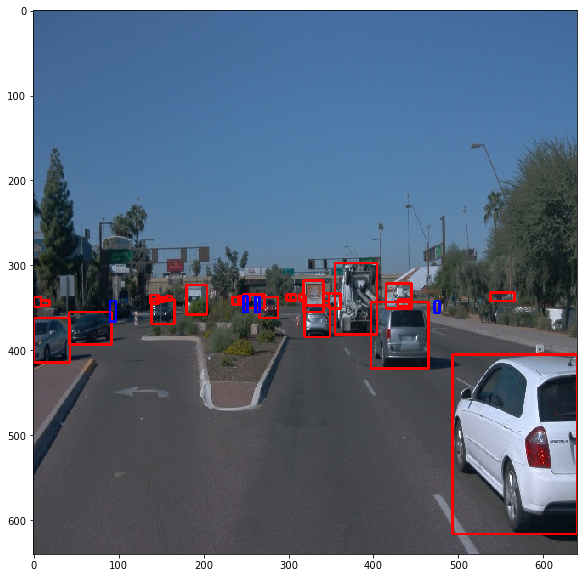

In [5]:
colors = generate_colors()

for train_ds in dataset.shuffle(buffer_size=10000).take(10):
    #print(repr(train_ds))
    display_instances(train_ds)

## Additional EDA

In this last part, you are free to perform any additional analysis of the dataset. What else would like to know about the data?
For example, think about data distribution. So far, you have only looked at a single file...

### Class Distribution

In [6]:
data_cnt = 0
class_cnt = {1: 0, 2: 0, 4: 0}
mean_pixel_vals = []

for idx, train_data in enumerate(dataset):
    data_cnt += 1
    image = train_data['image'].numpy()
    classes = train_data['groundtruth_classes'].numpy()
 
    for obj_class in classes:
        class_cnt[obj_class] += 1

    # Calculate the mean pixel value of the image
    mean_pixel_vals.append(np.mean(image))
    
    if data_cnt == 20000:
        break

print(f'Total number of data: {data_cnt}')

Total number of data: 20000


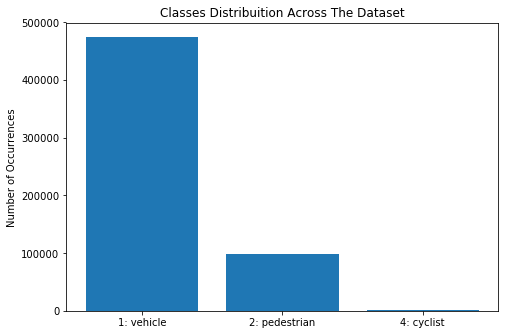

In [7]:
number_of_vehicles = class_cnt[1]
number_of_pedestrians = class_cnt[2]
number_of_cyclists = class_cnt[4]

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])

ax.set_title('Classes Distribuition Across The Dataset')
ax.set_ylabel('Number of Occurrences')

labels = ['1: vehicle', '2: pedestrian', '4: cyclist']
values = [number_of_vehicles, number_of_pedestrians, number_of_cyclists]
ax.bar(labels, values)
plt.show()

### Pixel Value Analysis

Text(0, 0.5, 'Frequeny')

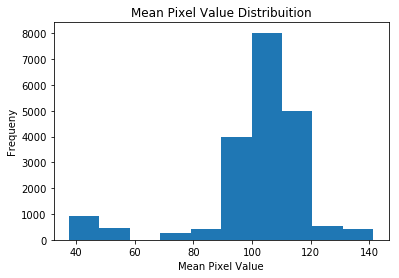

In [8]:
plt.hist(mean_pixel_vals)
plt.title('Mean Pixel Value Distribuition')
plt.xlabel('Mean Pixel Value')
plt.ylabel('Frequeny')

### Heat Map

In [9]:
def get_heat_map(heat_map, sigma):
    heat_map = gaussian_filter(heat_map, sigma)
    maxi = np.amax(heat_map)
    heat_map = heat_map * 1/maxi
    return heat_map

In [10]:
h, w = 640, 640

heatmap_vehicle = np.zeros((h,w))
heatmap_pedestrain = np.zeros((h,w))
heatmap_cyclist = np.zeros((h,w))

for idx, train_data in enumerate(dataset.shuffle(buffer_size=10000).take(5000)):
    
    image = train_data['image'].numpy()
    bboxes = train_data['groundtruth_boxes'].numpy()
    classes = train_data['groundtruth_classes'].numpy()
    
    for box, obj_class in zip(bboxes, classes):
        ymin = box[0]
        xmin = box[1]
        ymax = box[2]
        xmax = box[3]
        x1 = int(xmin * w)
        y1 = int(ymin * h)
        x2 = int(xmax * w)
        y2 = int(ymax * h)
    
        cx, cy = (x1+x2)//2, (y1+y2)//2
        if obj_class == 1:
            heatmap_vehicle = cv2.circle(heatmap_vehicle,(cx,cy), 1, 1, -1)
        elif obj_class == 2:
            heatmap_pedestrain = cv2.circle(heatmap_pedestrain,(cx,cy), 1, 1, -1)
        elif obj_class == 4:
            heatmap_cyclist = cv2.circle(heatmap_cyclist,(cx,cy), 1, 1, -1)

heatmap_vehicle = get_heat_map(heatmap_vehicle, sigma=3)
heatmap_pedestrain = get_heat_map(heatmap_pedestrain, sigma=3)
heatmap_cyclist = get_heat_map(heatmap_cyclist, sigma=3)


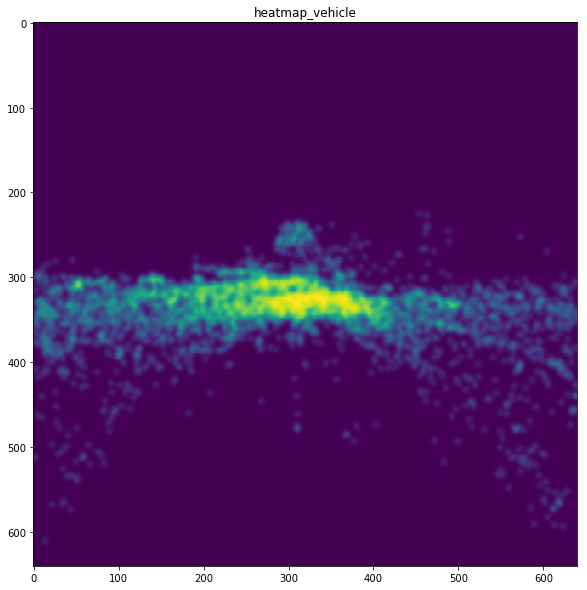

In [11]:
f, (ax1) = plt.subplots(1, 1, figsize=(10,10))
f.subplots_adjust(hspace = .2, wspace = .05)
plt.title('heatmap_vehicle')
ax1.imshow(heatmap_vehicle)

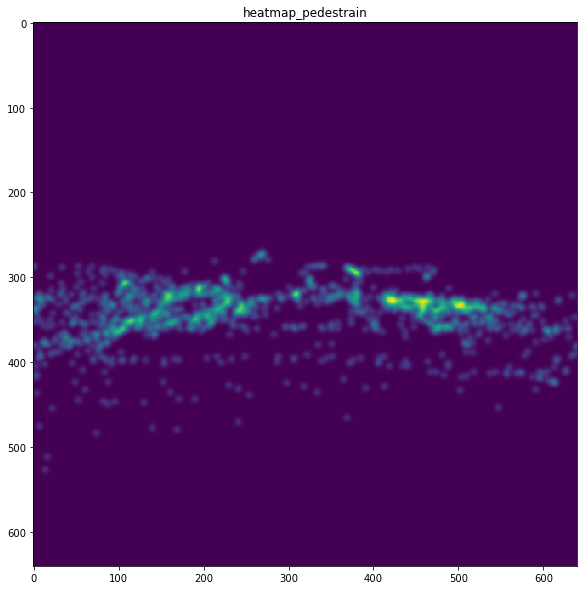

In [12]:
f, (ax1) = plt.subplots(1, 1, figsize=(10,10))
f.subplots_adjust(hspace = .2, wspace = .05)
plt.title('heatmap_pedestrain')
ax1.imshow(heatmap_pedestrain)

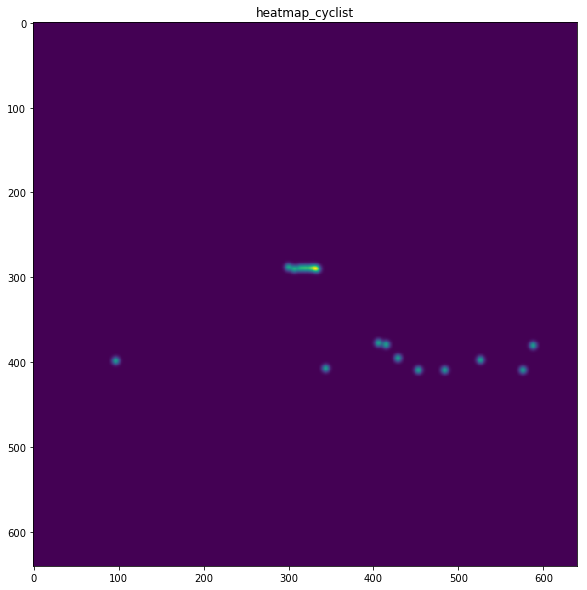

In [13]:
f, (ax1) = plt.subplots(1, 1, figsize=(10,10))
f.subplots_adjust(hspace = .2, wspace = .05)
plt.title('heatmap_cyclist')
ax1.imshow(heatmap_cyclist)